<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Lyrics Analysis

This section is the continuation of the previous **songs-EDA**, where I performed the exploratory data analysis, cleaning the data, creating the features and looking at some interesting insights.<br><br>

Here I want to do a little bit of extra analysis related to the words used in various songs, and also try to create a classificator, that will be able to distinguish whether some lyrics belongs to specified genre.<br><br>

Here I used **GPU-accelerated ML API** - **cuML** by RapidAI for the first time, in order to make the calculations faster, knowing that the API is based on sklearn syntax. However Sparse Dataframes don't cooperate with this API well. So I used mostly classic **sklearn** modules, however I find it enjoyable to test the GPU versions.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tt_split
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB as MNB

import cupy
import cudf
import cupyx
from cuml.model_selection import GridSearchCV, train_test_split
from cuml.naive_bayes import MultinomialNB
from cuml.svm import LinearSVC
from cuml.linear_model import LogisticRegression
from cuml.cluster import DBSCAN, AgglomerativeClustering, KMeans as CKMeans
#from cuml.feature_extraction.text import TfidfVectorizer

sns.set_style("whitegrid")
sns.set_palette("inferno")

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Loading the previously prepared data

In [2]:
df = pd.read_csv("lyrics_data.csv")

In [3]:
df.head(1)

,song_title,song_release_date,featured,song_popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,...,artist_popularity,artist_followers,album_name,album_total_tracks,album_popularity,lyrics,genre,day_of_week,release_year,duration
0,It's All Over Now - Mono Version,1964-10-17,0,47,0.0235,0.603,0.689,0.000003,0.33,-10.729,...,79.0,14083807.0,12 X 5,12,45,"Well, baby used to stay out all night long Sh...",rock,Saturday,1964,206.0


<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Creating the features out of words

In [4]:
lyrics_data = df["lyrics"]
vectorizer = TfidfVectorizer(max_features=10000)
words = vectorizer.fit_transform(lyrics_data)

In [5]:
words_df = pd.DataFrame.sparse.from_spmatrix(words, columns=vectorizer.get_feature_names_out())

In [6]:
df = df.rename(columns={"energy": "energy_level", "danceability": "danceability_level",
                                              "key": "key_level", "loudness": "loudness_level",
                                              "valence": "valence_level", "tempo": "tempo_level",
                                              "genre": "artist_genre", "featured": "is_feat",
                                              "duration": "duration_s", "energy": "energy_level"})
data = pd.concat([df.drop(["lyrics", "acousticness", "instrumentalness", "mode", "liveness"], axis=1), words_df], axis=1)

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Let's count the total frequency of the curse words

In [7]:
curse_words = ["fuck", "shit", "bitch", "ass", "asshole", "slut", "whore", "motherfucker", "piss", "cunt", "damn", "dick", "pussy", "bullshit", "bastard"]
data["curse_words"] = 0
for c_word in curse_words:
    try:
        data["curse_words"] += data[c_word]
    except:
        pass

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Curse words frequency across genres

Obviously rap scores at the 1st place of this ranking.

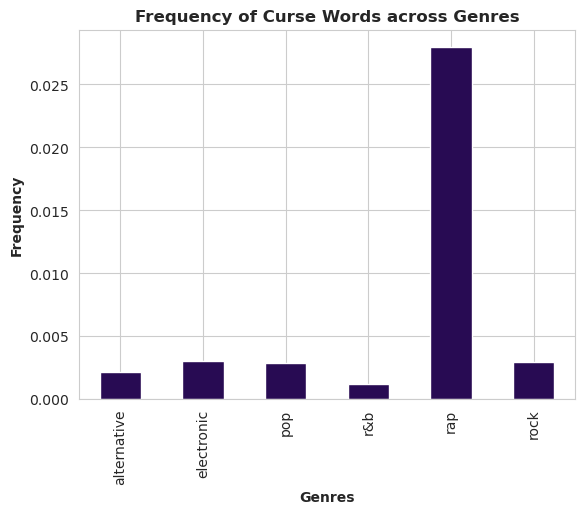

In [8]:
data.groupby("artist_genre")["curse_words"].mean().plot(kind="bar")
plt.title("Frequency of Curse Words across Genres", weight="bold")
plt.xlabel("Genres", weight="bold")
plt.ylabel("Frequency", weight="bold")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Cursing in songs across years

Let's see some most popular curse words and the overall across the years.<br><br>

Looks like the trend is growing, nowadays there is **way more curse words** in the songs.

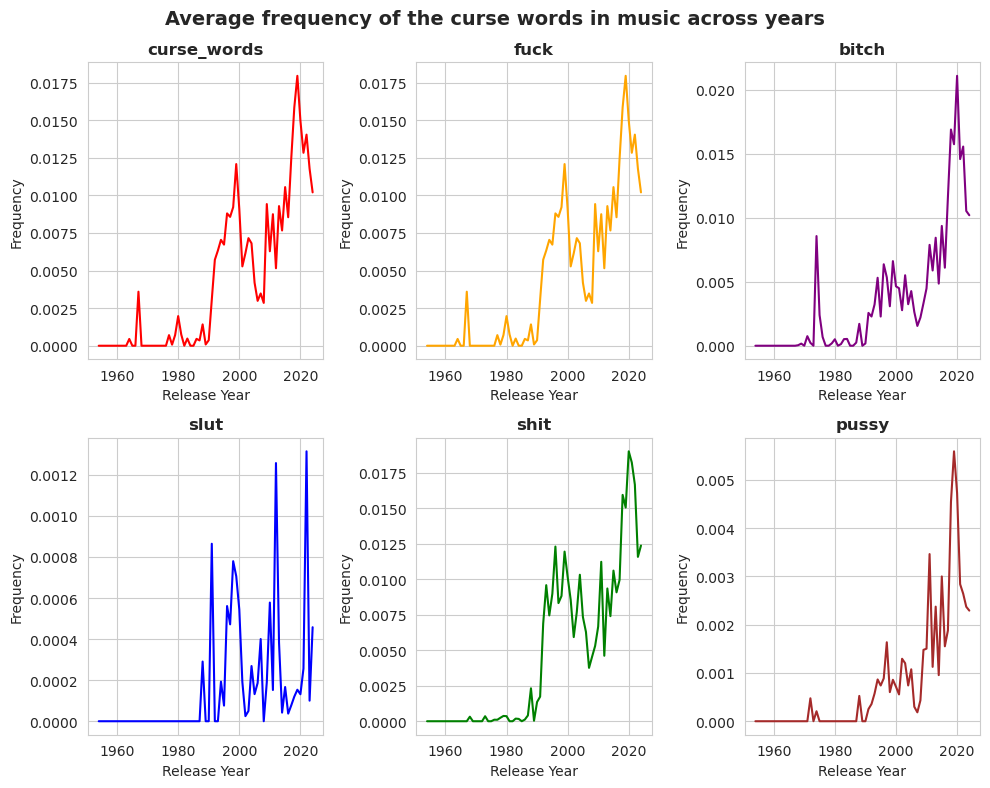

In [30]:
fig, axes = plt.subplots(figsize=(10,8), nrows=2, ncols=3)

for ax, col, color in zip(axes.flatten(), ["curse_words", "fuck", "bitch", "slut", "shit", "pussy"], ["red", "orange", "purple", "blue", "green", "brown"]):
    sns.lineplot(data=data, x="release_year", y=col, errorbar=None, ax=ax, c=color)
    ax.set_title(col, weight="bold")
    ax.set_xlabel("Release Year")
    ax.set_ylabel("Frequency")
fig.suptitle("Average frequency of the curse words in music across years", weight="bold", fontsize=14)
plt.tight_layout()
plt.show()

fig.savefig("figures/curse_words_over_time.jpg")

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Classify the genre

Let's try to create some classificator and see if it can perform at least quite well. <br>

In [10]:
df_4 = pd.read_csv("lyrics_data.csv")
df_4 = df_4[df_4["genre"].isin(["rap", "pop", "rock", "r&b"])]

lyrics_data = df_4["lyrics"]
vectorizer = TfidfVectorizer(max_features=10000)
words = vectorizer.fit_transform(lyrics_data)

In [11]:
words_df = pd.DataFrame.sparse.from_spmatrix(words, columns=vectorizer.get_feature_names_out())

In [24]:
nb = MNB()

kmeans = KMeans()
mixture = GaussianMixture()
dbscan = DBSCAN()
aglo = AgglomerativeClustering()

In [16]:
lab_encoder = LabelEncoder()

X = words_df

y = lab_encoder.fit_transform(df_4["genre"].values)

In [17]:
X_train, X_test, y_train, y_test = tt_split(X, y, test_size=0.2, random_state=42)

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26979 entries, 0 to 26978
Columns: 10000 entries, 000 to 향해
dtypes: Sparse[float64, 0](10000)
memory usage: 34.6 MB


<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Checking if there is any clustering pattern

However the elbow is not strict, so knowing I am working with 4 genres here, I will pick k = 4.

In [20]:
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, max_iter=400, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

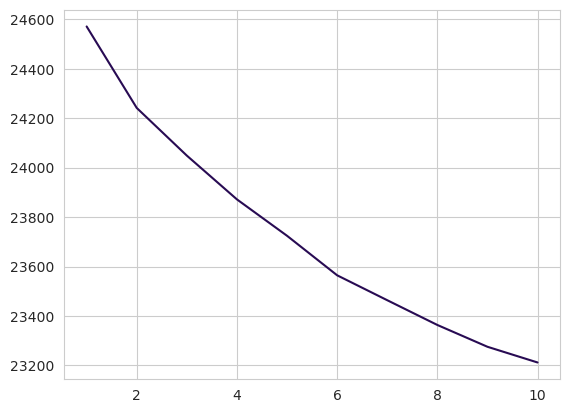

In [21]:
plt.figure()
plt.plot(range(1,11), inertias)
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Clustering results

KMeans specifies **rap** genre the most accurately, however the rest of the predictions are pretty random.

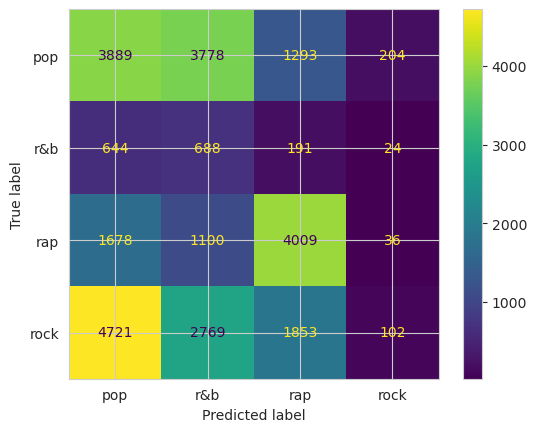

In [22]:
kmeans = KMeans(n_clusters=4, n_init=20, max_iter=400, random_state=42)
kmeans.fit(X)

ConfusionMatrixDisplay(confusion_matrix(y, kmeans.labels_), display_labels=lab_encoder.classes_).plot()
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Let's check the Naive Bayes

Naive Bayes works pretty well in classyfing every genre except of **R&B**.<br>
The reason for this is the imbalance in the training set.

In [25]:
nb.fit(X_train, y_train)

MultinomialNB()

In [26]:
y_pred = nb.predict(X_test)

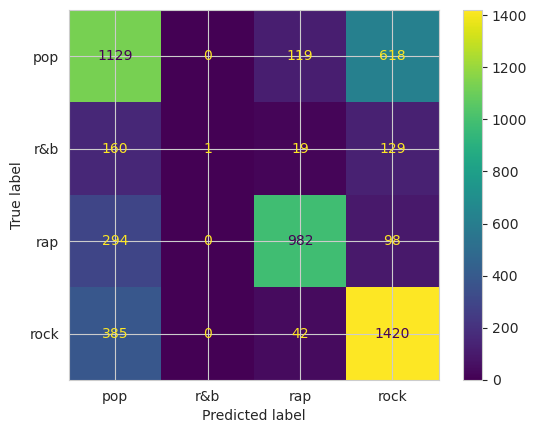

In [27]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=lab_encoder.classes_).plot()
plt.show()